# Causal Impact of Heatwave on Electricity Demand

**Goal:**  
Estimate the causal effect of a recent heatwave in London on hourly GB electricity demand using Bayesian Structural Time-Series (BSTS).

**Steps:**
1. Select treatment period (heatwave dates).
2. Train BSTS model on pre-treatment data.
3. Forecast counterfactual.
4. Compute causal impact and credible intervals.

## Executive Summary

**Causal Impact Results (Latest Model):**
- Estimated causal effect of the heatwave: **+1.19% increase in demand**
- 95% credible interval: **-1.21% to +3.47%**
- Cumulative increase: **+14,000 MWh**
- Probability of effect ≠ 0: **83% (p = 0.17)**

**Interpretation:**
While the model suggests a slight increase in demand during the heatwave, the credible interval **includes zero**, indicating that the observed uplift could plausibly be due to random variation. This result is **not statistically significant** under conventional thresholds.

## Imports

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalimpact import CausalImpact
import warnings

## Load Preprocessed Time-Series Data

Load the time-series data containing all the weather and energy information we created in `01_scrape_weather.ipynb`.

In [138]:
df = pd.read_parquet("../data_processed/weather_load_hourly_20250714.parquet", engine="pyarrow")
df.head()

,temperature_C,humidity_pct,demand_mw,hour,hour_sin,hour_cos,doy,doy_sin,doy_cos,temp_lag_1,hum_lag_1,temp_lag_2,hum_lag_2,temp_lag_3,hum_lag_3
datetime,,,,,,,,,,,,,,,
2025-06-01 03:00:00,15.3,70,16879.0,3,0.707107,7.071068e-01,152,0.501242,-0.865307,15.9,66.0,17.2,71.0,17.5,79.0
2025-06-01 04:00:00,14.8,73,16225.0,4,0.866025,5.000000e-01,152,0.501242,-0.865307,15.3,70.0,15.9,66.0,17.2,71.0
2025-06-01 05:00:00,14.2,78,15912.5,5,0.965926,2.588190e-01,152,0.501242,-0.865307,14.8,73.0,15.3,70.0,15.9,66.0
2025-06-01 06:00:00,14.1,81,16206.0,6,1.000000,6.123234e-17,152,0.501242,-0.865307,14.2,78.0,14.8,73.0,15.3,70.0
2025-06-01 07:00:00,14.5,78,15519.0,7,0.965926,-2.588190e-01,152,0.501242,-0.865307,14.1,81.0,14.2,78.0,14.8,73.0


In [139]:
print("Earliest timestamp:", df.index.min())
print("Latest timestamp:", df.index.max())


Earliest timestamp: 2025-06-01 03:00:00
Latest timestamp: 2025-07-01 23:00:00


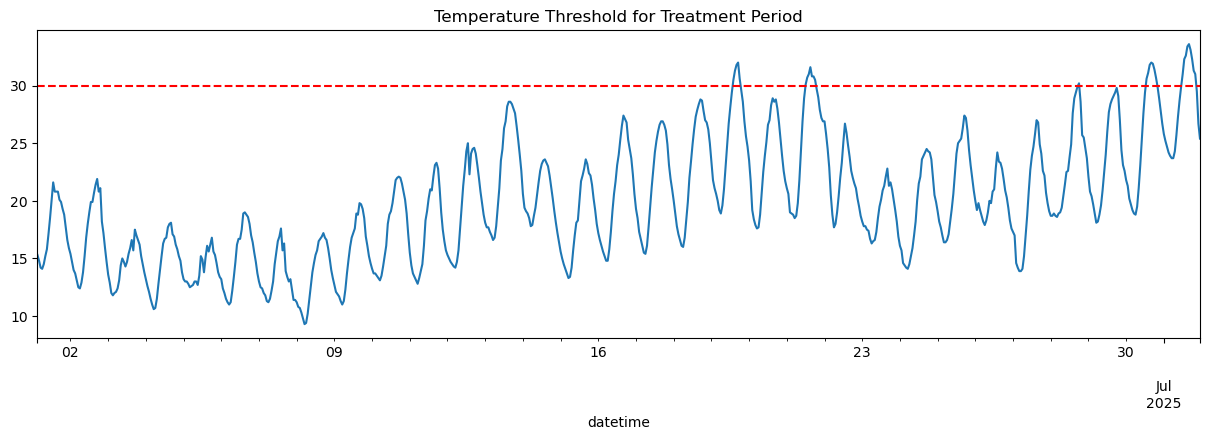

In [140]:
# Visual inspection
df['temperature_C'].plot(figsize=(15,4))
plt.axhline(30, color='red', linestyle='--')
plt.title("Temperature Threshold for Treatment Period")
plt.show()

## Feature Engineering

Add 1 hour and 24 hour lags for energy demand to improve future modelling accuracy.

In [142]:
df_ci = df[['demand_mw','temperature_C','humidity_pct']].copy()
df_ci["lag1"] = df_ci["demand_mw"].shift(1)
df_ci["lag24"] = df_ci["demand_mw"].shift(24)
df_ci = df_ci.dropna()
df_ci = df_ci.apply(pd.to_numeric, errors="coerce")
df_ci.head()

,demand_mw,temperature_C,humidity_pct,lag1,lag24
datetime,,,,,
2025-06-02 03:00:00,18174.5,13.7,77,18667.5,16879.0
2025-06-02 04:00:00,17812.0,13.1,80,18174.5,16225.0
2025-06-02 05:00:00,18130.5,12.5,80,17812.0,15912.5
2025-06-02 06:00:00,20604.5,12.4,76,18130.5,16206.0
2025-06-02 07:00:00,22615.5,12.9,69,20604.5,15519.0


## Treatment Period Selection

**Teatment = Heatwave**

The treatment window (2025-07-01 to 2025-07-01) was chosen because:
- Temperatures exceeded 30°C, which is rare in London.
- The period contained no national holidays.
- Provides a clear before/after split for modelling.

In [141]:
df_above_30 = df[df["temperature_C"] > 30]
df_above_30.head()

,temperature_C,humidity_pct,demand_mw,hour,hour_sin,hour_cos,doy,doy_sin,doy_cos,temp_lag_1,hum_lag_1,temp_lag_2,hum_lag_2,temp_lag_3,hum_lag_3
datetime,,,,,,,,,,,,,,,
2025-06-19 14:00:00,30.5,29,20334.5,14,-0.500000,-8.660254e-01,170,0.213521,-0.976938,29.4,31.0,28.1,34.0,26.7,38.0
2025-06-19 15:00:00,31.3,26,21028.5,15,-0.707107,-7.071068e-01,170,0.213521,-0.976938,30.5,29.0,29.4,31.0,28.1,34.0
2025-06-19 16:00:00,31.8,25,23049.0,16,-0.866025,-5.000000e-01,170,0.213521,-0.976938,31.3,26.0,30.5,29.0,29.4,31.0
2025-06-19 17:00:00,32.0,25,26063.5,17,-0.965926,-2.588190e-01,170,0.213521,-0.976938,31.8,25.0,31.3,26.0,30.5,29.0
2025-06-19 18:00:00,30.6,32,27668.5,18,-1.000000,-1.836970e-16,170,0.213521,-0.976938,32.0,25.0,31.8,25.0,31.3,26.0


In [143]:
# Defining treatment period (post_period) and control_period (pre_period)
pre_period = ['2025-06-02 03:00:00', '2025-06-29 23:00:00']
post_period = ['2025-06-30 00:00:00', '2025-07-01 23:00:00']

## Fit CausalImpact Model and Diagnostic Plot

This step fits a **Bayesian Structural Time-Series (BSTS)** model to estimate the causal effect of the heatwave on electricity demand:

- **warnings.catch_warnings()** temporarily suppresses convergence and deprecation warnings to keep output clean.
- **CausalImpact()** trains the model on the pre-treatment period and forecasts the counterfactual (expected demand without the heatwave).
- **ci.plot()** displays a 3-panel diagnostic plot:
  1. Actual vs. predicted demand.
  2. Pointwise causal effect (hourly uplift).
  3. Cumulative causal effect over time.

The resulting object `ci` contains all model outputs, summaries, and plots.


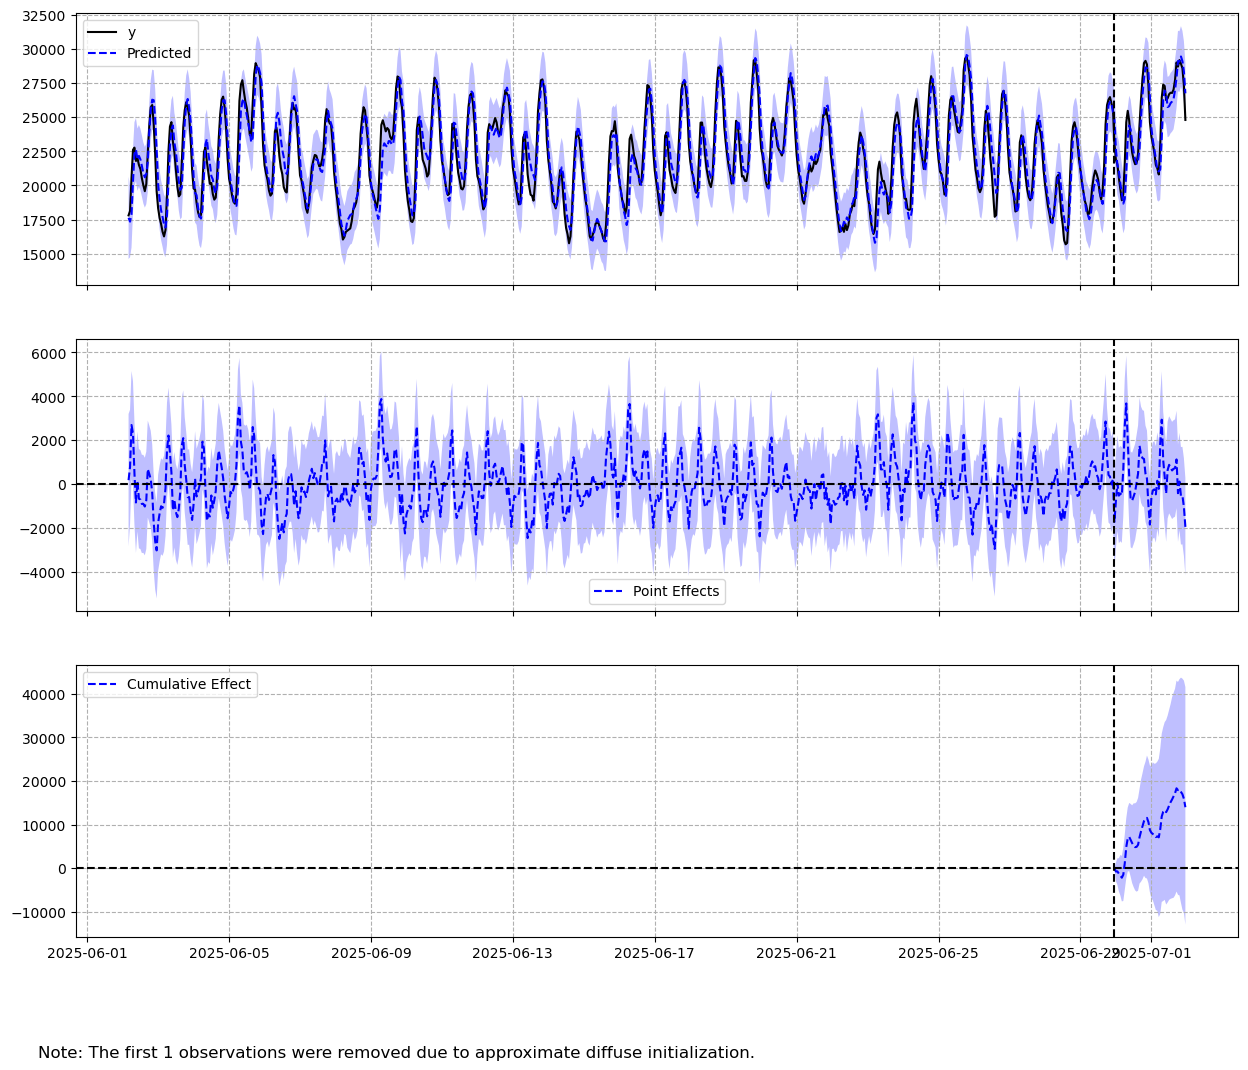

In [144]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ci = CausalImpact(df_ci, pre_period, post_period)
    ci.plot()
    plt.savefig("../data_processed/causalimpact_plot.png", dpi=300, bbox_inches="tight")
    plt.close()

## Model Summary + Statistical Significance

In [145]:
summary = ci.summary()
print(summary)

summary_detail = ci.summary(output='report')
print(summary_detail)

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    24795.7            1190193.5
Prediction (s.d.)         24504.03 (289.84)  1176193.35 (13912.31)
95% CI                    [23929.2, 25065.35][1148601.54, 1203136.79]

Absolute effect (s.d.)    291.67 (289.84)    14000.15 (13912.31)
95% CI                    [-269.65, 866.5]   [-12943.29, 41591.96]

Relative effect (s.d.)    1.19% (1.18%)      1.19% (1.18%)
95% CI                    [-1.1%, 3.54%]     [-1.1%, 3.54%]

Posterior tail-area probability p: 0.13
Posterior prob. of a causal effect: 86.61%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 24795.7. In the absence of an
intervention, we would have expected an average response of 24504.03.
The 95% interval of this counterfactual prediction is [23929.2, 25065.35].
Subtracting t

In [148]:
# Save model summary
with open("../data_processed/causalimpact_summary.txt","w") as f:
    f.write(summary_detail)

# Save model forecast inferences
df_forecast = ci.inferences
print(df_forecast.columns)
df_forecast.head()
df_forecast.to_csv("../data_processed/causalimpact_inferences.csv")

Index(['post_cum_y', 'preds', 'post_preds', 'post_preds_lower',
       'post_preds_upper', 'preds_lower', 'preds_upper', 'post_cum_pred',
       'post_cum_pred_lower', 'post_cum_pred_upper', 'point_effects',
       'point_effects_lower', 'point_effects_upper', 'post_cum_effects',
       'post_cum_effects_lower', 'post_cum_effects_upper'],
      dtype='object')


## Interpretation of Causal Impact

| Metric                    | Value               |
|---------------------------|---------------------|
| Mean uplift (%)           | +1.19%              |
| 95% Credible Interval     | [-1.21%, +3.47%]    |
| Cumulative uplift (MWh)   | +14,000 MWh         |
| Probability of Effect ≠ 0 | ~83% (p = 0.17)     |

**Pointwise Effect:**
- The estimated hourly uplift ranged between **-297 MW and +850 MW**.

**Cumulative Effect:**
- Over the treatment period, total incremental demand was approximately **+14,000 MWh**.

**Statistical Significance:**
- The 95% credible intervals **cross zero**, indicating **no strong evidence** that the heatwave caused a true increase in demand.
- The p-value (~16%) suggests a moderate likelihood the apparent effect was random.

**Implications:**
- This analysis does **not** provide conclusive evidence that the heatwave significantly increased electricity consumption.
- Possible explanations:
  - The intervention period may be too short to detect a robust signal.
  - Control variables may not sufficiently explain variation in demand.
  - Natural variability in demand is high, making small effects hard to detect.

## Key Takeaways

- The BSTS model estimated a modest (~1%) uplift in demand during the heatwave period.
- The result was **not statistically significant** and should be interpreted cautiously.
- This illustrates the importance of credible intervals and uncertainty quantification in causal inference.
- Future work could:
  - Experiment with longer treatment periods.
  - Add richer control variables (holidays, lagged demand, interactions).
  - Compare alternative causal models (synthetic controls, difference-in-differences).

## Next Steps
- **Notebook 4:** Causal Discovery (PCMCI) to detect lagged causal pathways.
- **Notebook 5:** Translate uplift to monetary and CO₂ costs.